# HW2: Automatic Feature Matching
By Himanshu Jhawar (hj2713)

COMS4732W Computer Vision 2

Based on "Multi-Image Matching using Multi-Scale Oriented Patches" (Brown et al.)

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from PIL import Image, ImageOps
import harris
import os

%matplotlib inline
os.makedirs('results', exist_ok=True)
RESULTS_DIR = 'results/running_on_my_image'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [202]:
def load_image(path):
    pil_img = Image.open(path)
    pil_img = ImageOps.exif_transpose(pil_img)
    return np.array(pil_img)

# Load images
def get_images(path1, path2):
    im1 = load_image(path1)
    im2 = load_image(path2)
    gray1 = color.rgb2gray(im1[:,:,:3])
    gray2 = color.rgb2gray(im2[:,:,:3])
    return im1, im2, gray1, gray2

---
## Step 0: Original Images
Show your 2 images, as-is, side-by-side.

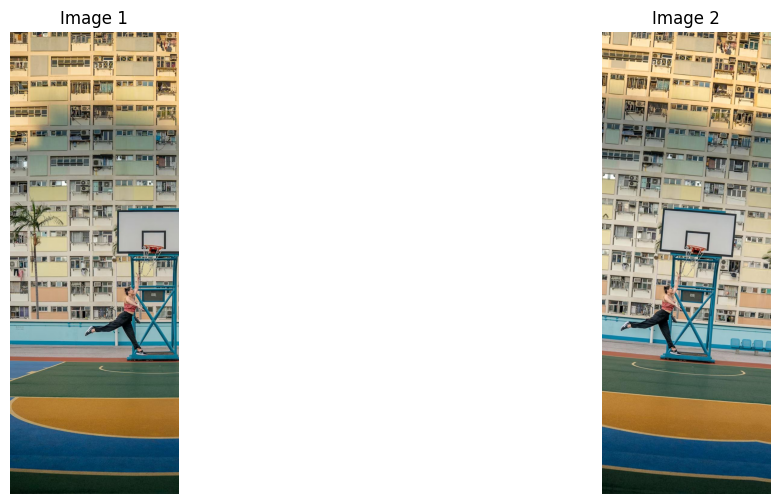

In [204]:
path1 = 'images/imgD1.jpg'
path2 = 'images/imgD2.jpg'
im1, im2, gray1, gray2 = get_images(path1, path2)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(im1); ax[0].set_title('Image 1'); ax[0].axis('off')
ax[1].imshow(im2); ax[1].set_title('Image 2'); ax[1].axis('off')
plt.savefig(f'{RESULTS_DIR}/step0_originals.png', dpi=150)
plt.show()

---
## Step 1: Harris Corner Detection
Using the provided `harris.py` (single scale, no sub-pixel accuracy).

**Deliverable:** Detected corners overlaid on both images side-by-side.

In [205]:
# Harris corner detection
def corners(gray1, gray2):
    h1, c1 = harris.get_harris_corners(gray1, edge_discard=20)
    h2, c2 = harris.get_harris_corners(gray2, edge_discard=20)
    print(f'Image 1: {c1.shape[1]} corners | Image 2: {c2.shape[1]} corners')
    return h1, c1, h2, c2

Image 1: 16777 corners | Image 2: 17176 corners


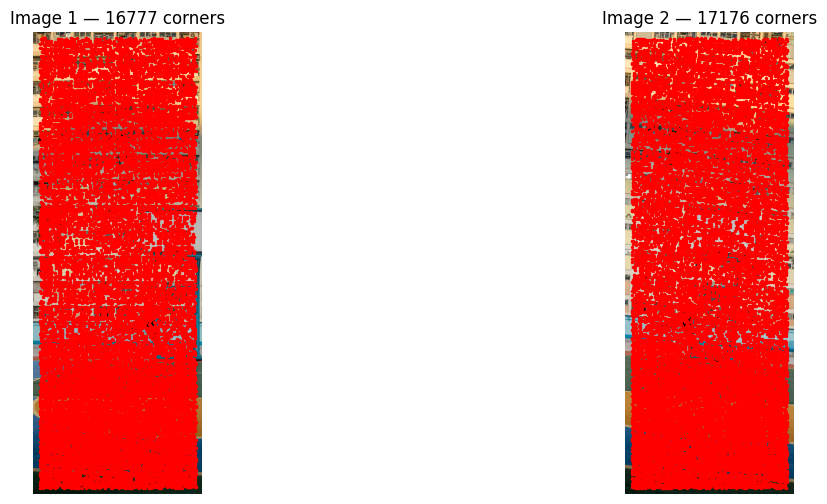

In [206]:
h1, c1, h2, c2 = corners(gray1, gray2)

# corners overlaid side-by-side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(im1); ax[0].plot(c1[1], c1[0], 'r.', ms=3); ax[0].set_title(f'Image 1 — {c1.shape[1]} corners'); ax[0].axis('off')
ax[1].imshow(im2); ax[1].plot(c2[1], c2[0], 'r.', ms=3); ax[1].set_title(f'Image 2 — {c2.shape[1]} corners'); ax[1].axis('off')
plt.savefig(f'{RESULTS_DIR}/step1_harris.png', dpi=150)
plt.show()

---
## Step 2: Non-Maximal Suppression
Discard corners that are not a local max in a window of chosen size.

**Deliverable:** Corners after NMS overlaid side-by-side. Window size used = 20.

In [207]:
from scipy.ndimage import maximum_filter

def nms(h, corners, window_size):
    """Keep only corners that are the local max in a window_size x window_size window."""
    local_max = maximum_filter(h, size=window_size)
    mask = []
    for i in range(corners.shape[1]):
        y, x = corners[0, i], corners[1, i]
        mask.append(h[y, x] == local_max[y, x])
    return corners[:, np.array(mask)]

# Apply NMS
def apply_nms(h1, c1, h2, c2):
    WINDOW_SIZE = 20  # window size
    nms_c1 = nms(h1, c1, WINDOW_SIZE)
    nms_c2 = nms(h2, c2, WINDOW_SIZE)
    print(f'Window size: {WINDOW_SIZE}')
    print(f'Image 1: {c1.shape[1]} → {nms_c1.shape[1]} corners')
    print(f'Image 2: {c2.shape[1]} → {nms_c2.shape[1]} corners')
    return nms_c1, nms_c2

Window size: 20
Image 1: 16777 → 1320 corners
Image 2: 17176 → 1319 corners


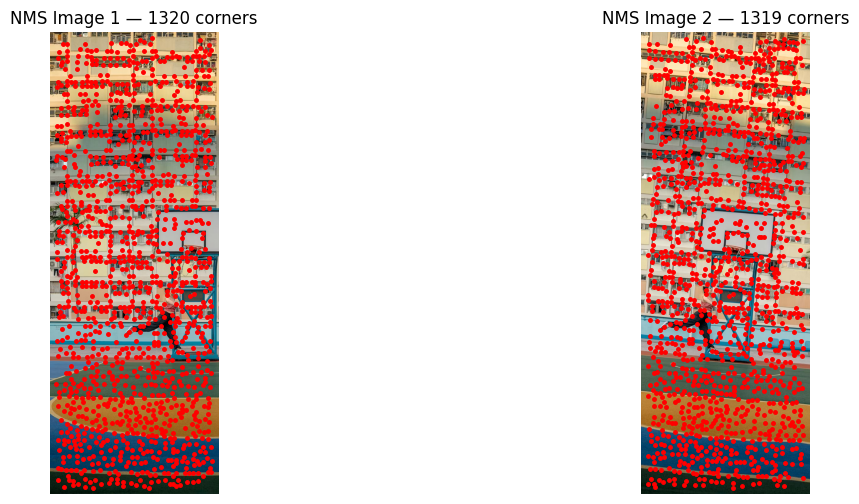

In [208]:
nms_c1, nms_c2 = apply_nms(h1, c1, h2, c2)

# NMS corners overlaid side-by-side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(im1); ax[0].plot(nms_c1[1], nms_c1[0], 'r.', ms=5); ax[0].set_title(f'NMS Image 1 — {nms_c1.shape[1]} corners'); ax[0].axis('off')
ax[1].imshow(im2); ax[1].plot(nms_c2[1], nms_c2[0], 'r.', ms=5); ax[1].set_title(f'NMS Image 2 — {nms_c2.shape[1]} corners'); ax[1].axis('off')
plt.savefig(f'{RESULTS_DIR}/step2_nms.png', dpi=150)
plt.show()

---
## Step 3: Feature Descriptor Extraction
Extract axis-aligned 8×8 patches from 40×40 windows (RGB). Downsample with anti-aliasing, then bias/gain-normalize.

Descriptors are **192-dimensional** (8×8×3 channels, flattened).

In [209]:
from skimage.transform import resize

def extract_descriptors(img, corners, patch_size=40, out_size=8):
    """
    img: HxWx3 RGB image
    corners: 2xN array (row 0 = ys, row 1 = xs)
    Returns: (descs, valid_corners)
        descs: Nx192 descriptors (flattened 8x8x3 RGB)
        valid_corners: 2xN array of corners that had a full patch
    """
    r = patch_size // 2
    h, w = img.shape[:2]
    ys, xs = corners
    desc_list, valid_list = [], []
    for y, x in zip(ys, xs):
        # skip if 40x40 window goes out of bounds
        if y - r < 0 or y + r > h or x - r < 0 or x + r > w:
            continue
        # crop 40x40x3 RGB window
        window = img[y - r : y + r, x - r : x + r].astype(np.float64)
        # downsample to 8x8x3 (anti_aliasing blurs before downsampling)
        small = resize(window, (out_size, out_size, 3), anti_aliasing=True)
        # bias/gain normalize: zero mean, unit variance
        v = small.flatten()
        v = (v - v.mean()) / (v.std() + 1e-8)
        desc_list.append(v)
        valid_list.append([y, x])
    dim = out_size * out_size * 3
    descs = np.vstack(desc_list) if desc_list else np.zeros((0, dim))
    valid = np.array(valid_list).T if valid_list else np.zeros((2, 0), dtype=int)
    return descs, valid

# Extract RGB descriptors for both images
desc1, pts1 = extract_descriptors(im1, nms_c1)
desc2, pts2 = extract_descriptors(im2, nms_c2)
print(f'Image 1: {desc1.shape[0]} descriptors')
print(f'Image 2: {desc2.shape[0]} descriptors')

Image 1: 1320 descriptors
Image 2: 1319 descriptors


---
## Step 4: Feature Matching (15 pts)
Lowe's ratio test (NNDR): threshold on ratio of 1st to 2nd nearest neighbor distances.

**Similarity metric:** L2 (Euclidean distance) via `scipy.spatial.distance.cdist`

**Deliverables:**
1. NNDR histogram with threshold highlighted
2. Match visualization (Option 2): green lines between matches, red dots on unmatched features
3. Top 5 best matches: img1 descriptor | 1NN from img2 | 2NN from img2 (RGB patches)


In [210]:
import importlib
import feature_matching
importlib.reload(feature_matching)

from scipy.spatial.distance import cdist

# L2 (Euclidean) distance between all descriptor pairs
dists = cdist(desc1, desc2, metric='euclidean')

# For each img1 descriptor, find 1NN and 2NN in img2
ratios, nn1_idx, nn2_idx = [], [], []
for i in range(dists.shape[0]):
    sorted_idx = np.argsort(dists[i])
    d1, d2 = dists[i, sorted_idx[0]], dists[i, sorted_idx[1]]
    ratios.append(d1 / (d2 + 1e-8))
    nn1_idx.append(sorted_idx[0])
    nn2_idx.append(sorted_idx[1])
ratios = np.array(ratios)
nn1_idx = np.array(nn1_idx)
nn2_idx = np.array(nn2_idx)

THRESHOLD = 0.5

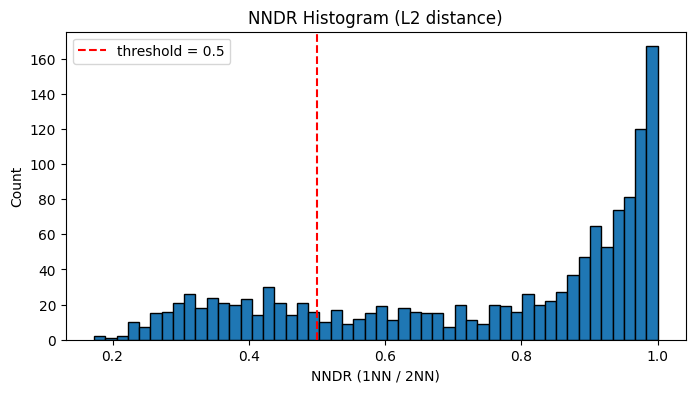

In [211]:
# Plot the histogram
feature_matching.plot_histogram(THRESHOLD, ratios, save_dir=RESULTS_DIR)

Threshold: 0.5 | Matched: 318 | Unmatched: 1002 | Total: 1320


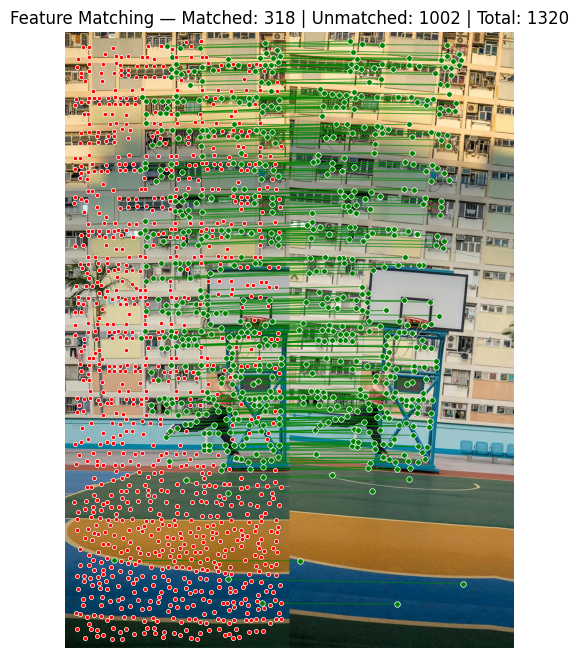

In [212]:
# Plot green lines red dot
feature_matching.plot_connected_descriptions(THRESHOLD, ratios, im1, im2, pts1, pts2, nn1_idx, nn2_idx, save_dir=RESULTS_DIR)

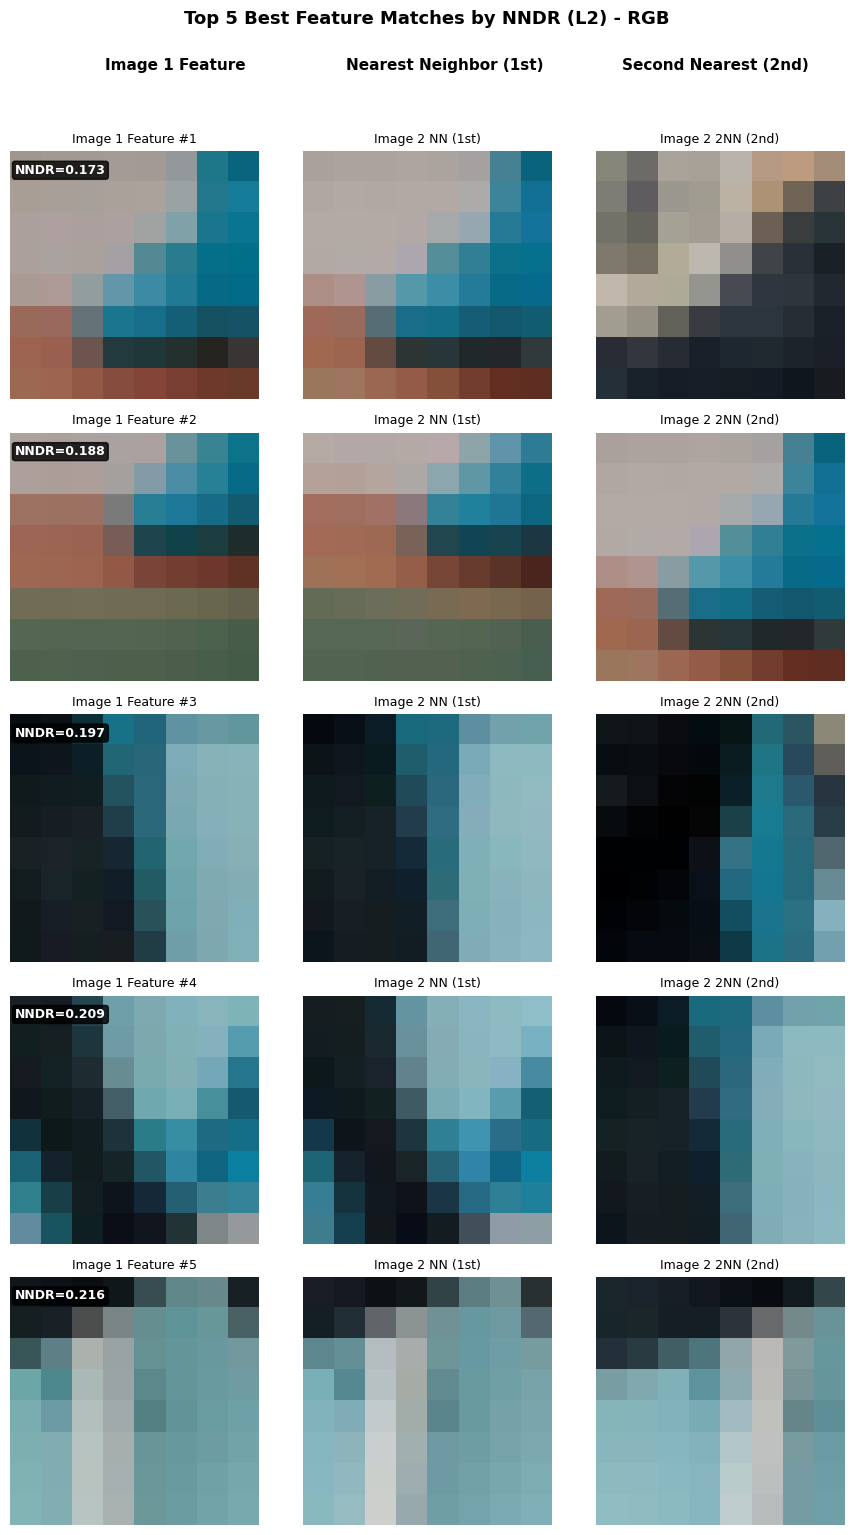

In [213]:
# Plot Top Feature Matches
match_mask = ratios < THRESHOLD
match_idx = np.where(match_mask)[0]

feature_matching.plot_top_feature_matches(ratios, match_mask, pts1, pts2, nn1_idx, nn2_idx, match_idx, im1, im2, save_dir=RESULTS_DIR)

---
## Extra Credit: Image Stitching/Panorama (10 pts)
Using **3 images** and the features computed in Steps 1–4:
1. Run the full pipeline (Harris → NMS → descriptors → NNDR matching) on pairs (C1↔C2) and (C2↔C3)
2. **RANSAC** (`skimage.measure.ransac`) to estimate projective homographies
3. Chain homographies: H₁₃ = H₁₂ × H₂₃
4. **Inverse warp** via `skimage.transform.warp` with `ProjectiveTransform`
5. **Blend** by averaging in overlap regions


Window size: 20
Image 1: 6068 → 390 corners
Image 2: 5730 → 362 corners
Window size: 20
Image 1: 5730 → 362 corners
Image 2: 5469 → 372 corners
C1↔C2: 144 matches | C2↔C3: 158 matches
H12 (C2→C1):
  RANSAC inliers: 140/144
H23 (C3→C2):
  RANSAC inliers: 148/158


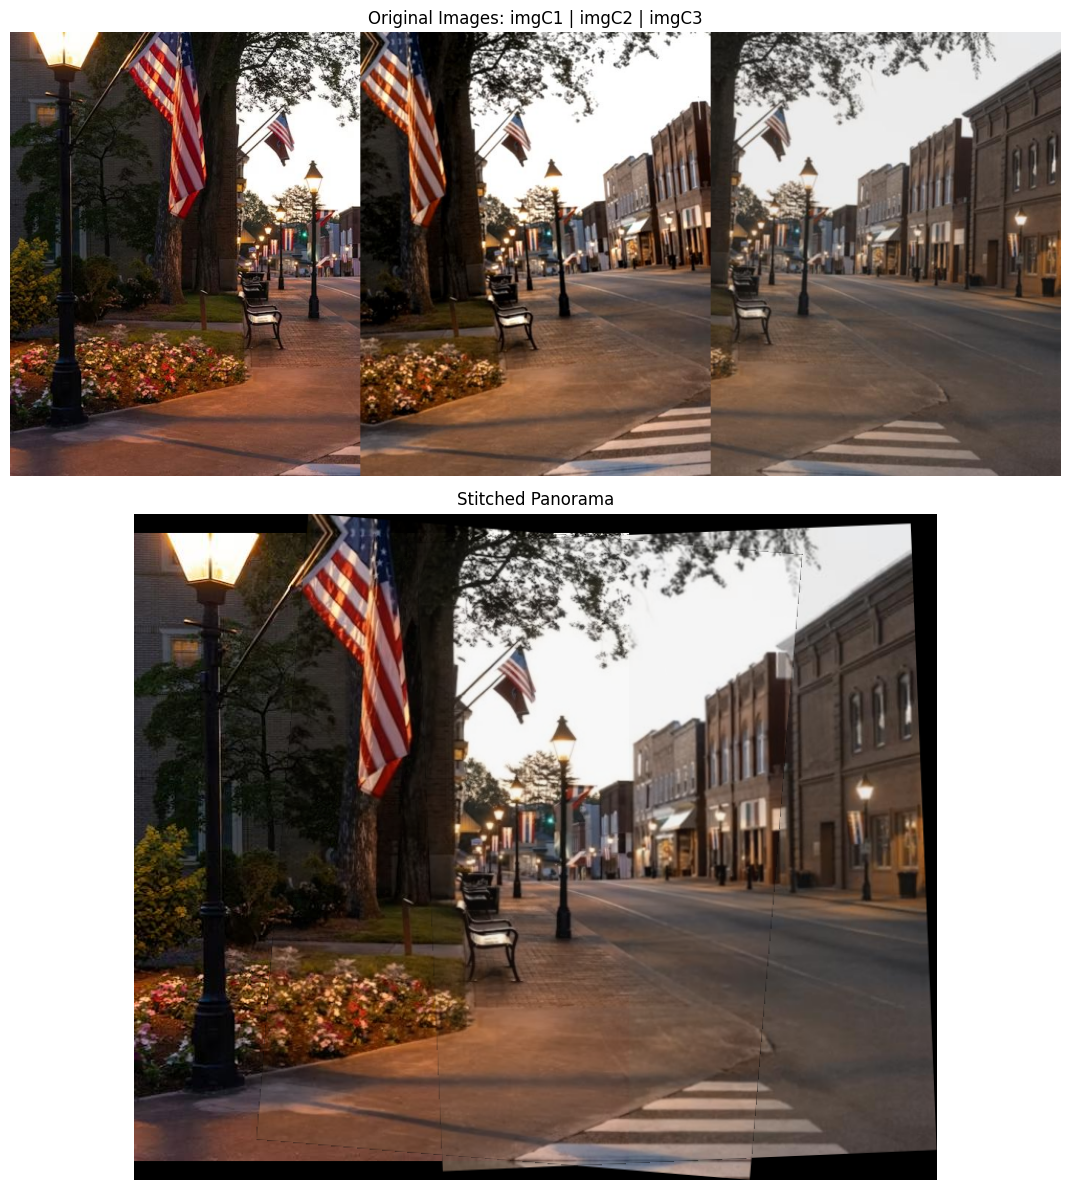

In [200]:
from skimage.transform import ProjectiveTransform, warp
from skimage.measure import ransac

# --- Load 3 images ---
imC1 = load_image('images/imgC1.jpg')
imC2 = load_image('images/imgC2.jpg')
imC3 = load_image('images/imgC3.jpg')
gC1, gC2, gC3 = color.rgb2gray(imC1[:,:,:3]), color.rgb2gray(imC2[:,:,:3]), color.rgb2gray(imC3[:,:,:3])

# --- Run pipeline on each image: Harris → NMS → Descriptors ---
h_1, c_1 = harris.get_harris_corners(gC1, edge_discard=20)
h_2, c_2 = harris.get_harris_corners(gC2, edge_discard=20)
h_3, c_3 = harris.get_harris_corners(gC3, edge_discard=20)

nC1, nC2_a = apply_nms(h_1, c_1, h_2, c_2)
_, nC3 = apply_nms(h_2, c_2, h_3, c_3)
nC2_b = nC2_a  # same NMS result for imgC2

dC1, pC1 = extract_descriptors(imC1, nC1)
dC2, pC2 = extract_descriptors(imC2, nC2_a)
dC3, pC3 = extract_descriptors(imC3, nC3)

# --- Match pairs: (C1,C2) and (C2,C3) ---
def match_pair(descA, descB):
    from scipy.spatial.distance import cdist
    dists = cdist(descA, descB, metric='euclidean')
    ratios, nn1, nn2 = [], [], []
    for i in range(dists.shape[0]):
        idx = np.argsort(dists[i])
        ratios.append(dists[i, idx[0]] / (dists[i, idx[1]] + 1e-8))
        nn1.append(idx[0]); nn2.append(idx[1])
    return np.array(ratios), np.array(nn1), np.array(nn2)

T = 0.7
r12, nn1_12, nn2_12 = match_pair(dC1, dC2)
r23, nn1_23, nn2_23 = match_pair(dC2, dC3)
m12 = np.where(r12 < T)[0]
m23 = np.where(r23 < T)[0]
print(f'C1↔C2: {len(m12)} matches | C2↔C3: {len(m23)} matches')

# --- RANSAC homographies ---
def get_homography(ptsA, ptsB, nn1, matches):
    src = np.array([[ptsB[1, nn1[i]], ptsB[0, nn1[i]]] for i in matches])
    dst = np.array([[ptsA[1, i], ptsA[0, i]] for i in matches])
    model, inliers = ransac((src, dst), ProjectiveTransform,
                            min_samples=4, residual_threshold=4, max_trials=2000)
    print(f'  RANSAC inliers: {inliers.sum()}/{len(inliers)}')
    return model, inliers

print('H12 (C2→C1):')
H12, inliers12 = get_homography(pC1, pC2, nn1_12, m12)
print('H23 (C3→C2):')
H23, inliers23 = get_homography(pC2, pC3, nn1_23, m23)

# Chain: C3→C1 = H12 @ H23
H13 = ProjectiveTransform(matrix=H12.params @ H23.params)

# --- Compute canvas and warp ---
h1, w1 = imC1.shape[:2]
h2, w2 = imC2.shape[:2]
h3, w3 = imC3.shape[:2]

corners = np.vstack([
    [[0,0],[w1,0],[w1,h1],[0,h1]],
    H12(np.array([[0,0],[w2,0],[w2,h2],[0,h2]])),
    H13(np.array([[0,0],[w3,0],[w3,h3],[0,h3]]))
])
mn = np.floor(corners.min(axis=0)).astype(int)
mx = np.ceil(corners.max(axis=0)).astype(int)
out_w, out_h = mx[0]-mn[0], mx[1]-mn[1]

shift = np.array([[1,0,-mn[0]],[0,1,-mn[1]],[0,0,1]], dtype=float)

wC2 = warp(imC2, ProjectiveTransform(matrix=shift @ H12.params).inverse,
           output_shape=(out_h, out_w), preserve_range=True).astype(np.uint8)
wC3 = warp(imC3, ProjectiveTransform(matrix=shift @ H13.params).inverse,
           output_shape=(out_h, out_w), preserve_range=True).astype(np.uint8)

# Place C1 and blend
canvas = np.zeros((out_h, out_w, 3), dtype=np.float64)
counts = np.zeros((out_h, out_w), dtype=np.float64)

yo, xo = -mn[1], -mn[0]
canvas[yo:yo+h1, xo:xo+w1] += imC1[:,:,:3].astype(float)
counts[yo:yo+h1, xo:xo+w1] += 1

for w_img in [wC2, wC3]:
    mask = w_img.sum(axis=2) > 0
    canvas[mask] += w_img[mask].astype(float)
    counts[mask] += 1

counts[counts == 0] = 1
result = (canvas / counts[:,:,None]).astype(np.uint8)

# --- Display: Row 1 = 3 images, Row 2 = panorama ---
fig, axes = plt.subplots(2, 1, figsize=(18, 12),
                         gridspec_kw={'height_ratios': [1, 1.5]})
# Row 1: originals side by side
row1 = np.concatenate([imC1[:,:,:3], imC2[:,:,:3], imC3[:,:,:3]], axis=1)
axes[0].imshow(row1)
axes[0].set_title('Original Images: imgC1 | imgC2 | imgC3')
axes[0].axis('off')
# Row 2: panorama
axes[1].imshow(result)
axes[1].set_title('Stitched Panorama')
axes[1].axis('off')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/extra_credit_panorama.png', dpi=150, bbox_inches='tight')
plt.show()


=== imgC1 ↔ imgC2 ===
Threshold: 0.7 | Matched: 144 | Unmatched: 246 | Total: 390


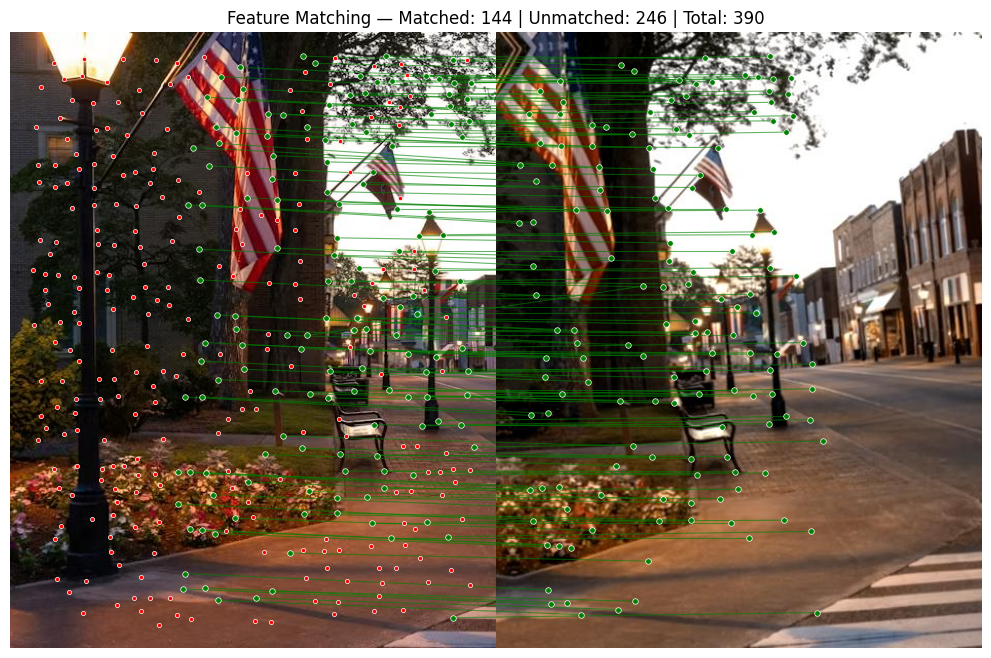

=== imgC2 ↔ imgC3 ===
Threshold: 0.7 | Matched: 158 | Unmatched: 204 | Total: 362


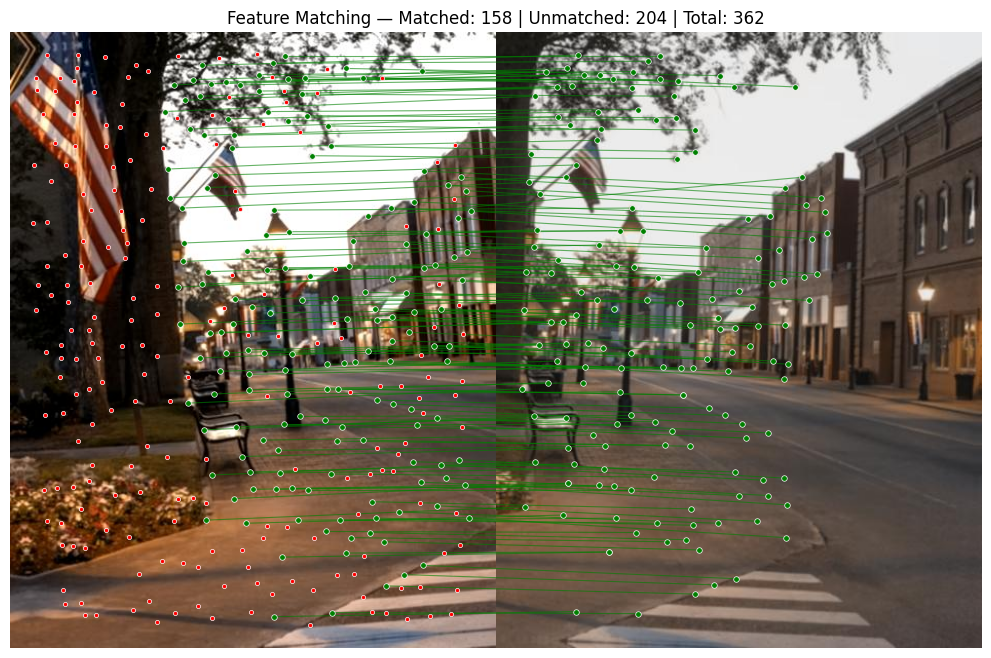

In [199]:
# --- Show match details for each pair ---
print('=== imgC1 ↔ imgC2 ===')
feature_matching.plot_connected_descriptions(T, r12, imC1, imC2, pC1, pC2, nn1_12, nn2_12, save_dir=RESULTS_DIR)

print('=== imgC2 ↔ imgC3 ===')
feature_matching.plot_connected_descriptions(T, r23, imC2, imC3, pC2, pC3, nn1_23, nn2_23, save_dir=RESULTS_DIR)
